<a href="https://colab.research.google.com/github/AlenaAntipina/KungfuGameDetector/blob/main/RL_ITMO_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mastering A2C (and Kung-Fu)**

Acknowledgements for this assignment to the [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt
from google.colab import output
output.clear()

Перезагрузка

In [ ]:
import os
import sys

if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/atari_util.py
    !wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/env_pool.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Selecting previously unselected package xvfb.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In this notebook we'll train RL agent for for atari [KungFu](https://gym.openai.com/envs/KungFuMaster-v0), this time using recurrent neural networks.



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%writefile atari_util.py
"""Auxilary files for those who wanted to solve breakout with CEM or policy gradient"""
import numpy as np
from gym.core import Wrapper
from gym.spaces.box import Box
from skimage.transform import resize

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False,
                 crop=lambda img: img, n_frames=4, dim_order='theano'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop = crop
        self.color = color
        self.dim_order = dim_order

        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = \
            [n_channels, height, width] \
            if dim_order == 'theano' else \
            [height, width, n_channels]
        self.observation_space = Box(0.0,1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'uint8')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, r, done, info = self.env.step(action)
        # print(new_img.dtype)
        self.update_buffer(new_img)
        # print(self.framebuffer.dtype)
        return self.framebuffer, r, done, info

    ### image processing ###

    def update_buffer(self, img):
        img = self.preproc_image(img)
        
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        
        img = self.crop(img)
        
        
        #img = resize(img, self.img_size)
        #print(img.dtype)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2, 0, 1])  # [h, w, c] to [c, h, w]
        #img = img.astype('float32') / 255.
        return img


Overwriting atari_util.py


In [ ]:
%%writefile env_pool.py
"""
A thin wrapper for openAI gym environments that maintains a set of parallel games and has a method to generate
interaction sessions given agent one-step applier function.
"""

import numpy as np
from tqdm.notebook import trange

# A whole lot of space invaders
import torch
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


class EnvPool(object):
    def __init__(self, agent, make_env, n_parallel_games=1):
        """
        A special class that handles training on multiple parallel sessions
        and is capable of some auxilary actions like evaluating agent on one game session (See .evaluate()).

        :param agent: Agent which interacts with the environment.
        :param make_env: Factory that produces environments OR a name of the gym environment.
        :param n_games: Number of parallel games. One game by default.
        :param max_size: Max pool size by default (if appending sessions). By default, pool is not constrained in size.
        """
        # Create atari games.
        self.agent = agent
        self.make_env = make_env
        self.envs = [self.make_env() for _ in range(n_parallel_games)]
        #self.ptev_act = torch.tensor([0]*n_parallel_games, dtype=torch.long).to(device)
        

        # Initial observations.
        [env.reset() for env in self.envs]
        [[env.step(0) for _ in range(89)] for env in self.envs] 
        self.prev_observations = np.array([env.step(0)[0] for env in self.envs]) 

        self.prev_lifes = [(env.render('rgb_array')[45:46, 49:88, 0]==232).sum() for env in self.envs]



        self.prev_memory_states = agent.get_initial_state(n_parallel_games)

        # Whether particular session has just been terminated and needs
        # restarting.
        self.just_ended = [False] * len(self.envs)

    def interact(self, n_steps=100, verbose=False):
        """Generate interaction sessions with ataries (openAI gym atari environments)
        Sessions will have length n_steps. Each time one of games is finished, it is immediately getting reset
        and this time is recorded in is_alive_log (See returned values).

        :param n_steps: Length of an interaction.
        :returns: observation_seq, action_seq, reward_seq, is_alive_seq
        :rtype: a bunch of tensors [batch, tick, ...]
        """

        def env_step(i, action):
            if not self.just_ended[i]:
                new_observation, cur_reward, is_done, info = \
                    self.envs[i].step(action)
                life = (self.envs[i].render('rgb_array')[45:46,49:88,0]==232).sum()
                cur_reward -= (2 if life<self.prev_lifes[i] else 0)
                self.prev_lifes[i] = life
                  
                if is_done:
                    # Game ends now, will finalize on next tick.
                    self.just_ended[i] = True

                # note: is_alive=True in any case because environment is still
                # alive (last tick alive) in our notation.
                return new_observation, cur_reward, True, info
            else:
                # Reset environment, get new observation to be used on next
                # tick.
                self.envs[i].reset()
                
                for _ in range(89):
                    s, _, _, _ = self.envs[i].step(0)
                new_observation = s
                self.prev_lifes[i] = (self.envs[i].render('rgb_array')[45:46,49:88,0]==232).sum()

                # Reset memory for new episode.
                initial_memory_state = self.agent.get_initial_state(
                    batch_size=1)
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = initial_memory_state[m_i][0]

                if verbose:
                    print("env %i reloaded" % i)

                self.just_ended[i] = False

                return new_observation, 0, False, {'end': True}

        history_log = []

        # self.agent.prev_act = self.ptev_act 
        # self.agent.pev_obst_t = self.prev_ob 

        for i in range(n_steps):
            new_memory_states, readout = self.agent.step(
                self.prev_memory_states, self.prev_observations)
            actions = self.agent.sample_actions(readout)

            new_observations, cur_rewards, is_alive, infos = zip(
                *map(env_step, range(len(self.envs)), actions))
            # self.agent.prev_act = torch.tensor(actions, dtype=torch.long).to(device)

       
            # Append data tuple for this tick.
            history_log.append(
                (self.prev_observations, actions, cur_rewards, is_alive))

         

        # add last observation
        # dummy_actions = [0] * len(self.envs)
        # dummy_rewards = [0] * len(self.envs)
        # dummy_mask = [1] * len(self.envs)
        # history_log.append(
        #     (self.prev_observations,
        #      dummy_actions,
        #      dummy_rewards,
        #      dummy_mask))

        # cast to numpy arrays, transpose from [time, batch, ...] to [batch,
        # time, ...]
        # return history_log 
        # print(history_log)
        history_log = [
            np.array(tensor).swapaxes(0, 1)
            for tensor in zip(*history_log)
        ]
        observation_seq, action_seq, reward_seq, is_alive_seq = history_log

        return observation_seq, action_seq, reward_seq, is_alive_seq


Overwriting env_pool.py


In [ ]:
import gym
from atari_util import PreprocessAtari
from tqdm.notebook import trange
import matplotlib.pyplot as plt

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=64, width=128, crop=lambda img: img[100:164,26:154], color=True, n_frames=1
    )
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (3, 64, 128)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [ ]:
s = env.reset()
for _ in range(90):
    s, _, _, _ = env.step(0)

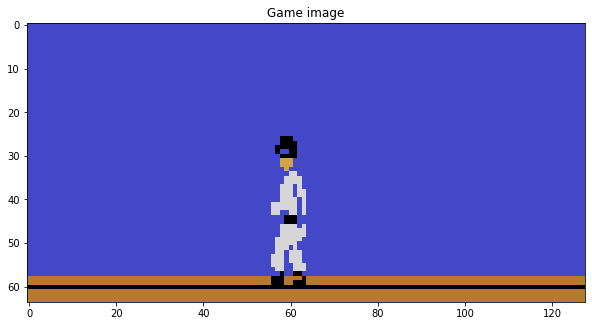

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Game image')
plt.imshow(s.transpose([1, 2, 0]))
plt.show()

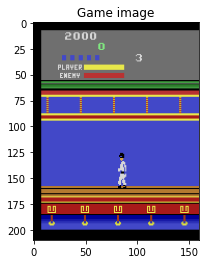

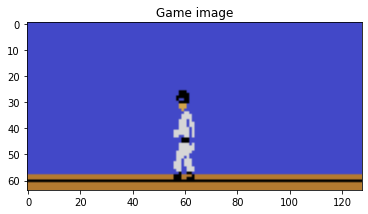

In [ ]:
import matplotlib.pyplot as plt


s = env.reset()
for _ in range(90):
   s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Game image')
plt.imshow(s.transpose([1, 2, 0]))
plt.show()


### POMDP setting

The atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this. Here's a sketch.

![img](https://github.com/girafe-ai/ml-mipt/blob/master/homeworks_advanced/Lab2_RL/img1.jpg?raw=1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, reuse=False, device=device):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()

        self.ConvLayer = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=(3, 5), stride=(2, 4)),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ELU(),
            nn.Flatten(1)
        )
        self.hid = nn.Sequential(
            nn.Linear(1568, 256),
            nn.ReLU() )
        self.rnn = nn.LSTMCell(256, 256)

        self.logits = nn.Linear(256, n_actions)
        self.state_value = nn.Linear(256, 1)
        self.device = device

    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation, 
        returns next state and whatever it needs to learn (tf tensors)
        """
        obs_t = torch.tensor(obs_t / 255, dtype=torch.float32).to(self.device) if not isinstance(obs_t, torch.Tensor) else obs_t / 255

        # YOUR CODE: apply the whole neural net for one step here.
        # See docs on self.rnn(...)
        # the recurrent cell should take the last feedforward dense layer as input
        x = self.ConvLayer(obs_t)
        x = self.hid(x)
        new_state = self.rnn(x, prev_state)
        y = new_state[0]
        logits = self.logits(new_state[0])
        state_value = self.state_value(y)

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return torch.zeros((batch_size, 256)).to(self.device), torch.zeros((batch_size, 256)).to(self.device)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits, dim=-1).cpu()
        return torch.multinomial(probs, 1)[:, 0].data.numpy()

    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is a numpy array """
        with torch.no_grad():
            (h, c), (l, s) = self.forward(prev_state, obs_t)
        return (h.detach(), c.detach()), (l.detach(), s.detach())

In [ ]:
n_parallel_games = 9
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions, device=device).to(device)

In [ ]:
state = env.reset()
_, (logits, value) = agent.step(agent.get_initial_state(1), state[None, ...])
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[-0.0051,  0.0340, -0.0501, -0.0315,  0.0271, -0.0176, -0.0456, -0.0055,
         -0.0415,  0.0583, -0.0398, -0.0580,  0.0421,  0.0119]])
state values:
 tensor([[0.0109]])


In [ ]:
logits.shape

torch.Size([1, 14])

### Let's play!
Let's build a function that measures agent's average reward.

In [ ]:
def evaluate(agent, env, n_games=1, is_agent=True):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in trange(n_games, leave=False):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)
        # prev_life = (env.render('rgb_array')[45:46,49:88,0]==232).sum()

        total_reward = 0
        for _ in range(89):
            observation, _, _, _ = env.step(0)
        #agent.pev_obst_t = torch.tensor(observation, dtype=torch.float).to(device)
        # agent.prev_act = torch.tensor([0], dtype=torch.long).to(device)
        while True:
            new_memories, readouts = agent.step(
                prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0] if is_agent else env.action_space.sample())
            if done:
                break

            total_reward += reward
            prev_memories = new_memories
            if done:
                break
            

        game_rewards.append(total_reward)
    return game_rewards

In [ ]:
! rm -r videos
with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    rw = evaluate(agent, env_monitor, n_games=1, is_agent=False)
print(rw)

  0%|          | 0/1 [00:00<?, ?it/s]

[300.0]


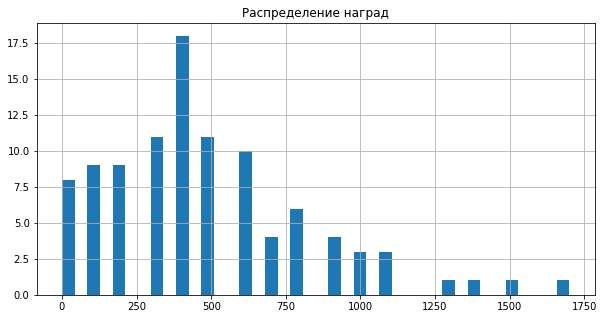

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(rw, bins=40)
plt.grid()
plt.title('Распределение наград')
plt.show()

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://github.com/girafe-ai/ml-mipt/blob/master/homeworks_advanced/Lab2_RL/img2.jpg?raw=1)

In [ ]:
from env_pool import EnvPool

In [ ]:
n_parallel_games = 2
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [ ]:
n_parallel_games

2

We gonna train our agent on a thing called __rollouts:__
![img](https://github.com/girafe-ai/ml-mipt/blob/master/homeworks_advanced/Lab2_RL/img3.jpg?raw=1)

A rollout is just a sequence of T observations, actions and rewards that agent took consequently.
* First __s0__ is not necessarily initial state for the environment
* Final state is not necessarily terminal
* We sample several parallel rollouts for efficiency

In [ ]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [ ]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (2, 10)
Rewards shape: (2, 10)
Mask shape: (2, 10)
Observations shape:  (2, 10, 3, 64, 128)


# Actor-critic objective

Here we define a loss function that uses rollout above to train advantage actor-critic agent.


Our loss consists of three components:

* __The policy "loss"__
 $$ \hat J = {1 \over T} \cdot \sum_t { \log \pi(a_t | s_t) } \cdot A_{const}(s,a) $$
  * This function has no meaning in and of itself, but it was built such that
  * $ \nabla \hat J = {1 \over N} \cdot \sum_t { \nabla \log \pi(a_t | s_t) } \cdot A(s,a) \approx \nabla E_{s, a \sim \pi} R(s,a) $
  * Therefore if we __maximize__ J_hat with gradient descent we will maximize expected reward
  
  
* __The value "loss"__
  $$ L_{td} = {1 \over T} \cdot \sum_t { [r + \gamma \cdot V_{const}(s_{t+1}) - V(s_t)] ^ 2 }$$
  * Ye Olde TD_loss from q-learning and alike
  * If we minimize this loss, V(s) will converge to $V_\pi(s) = E_{a \sim \pi(a | s)} R(s,a) $


* __Entropy Regularizer__
  $$ H = - {1 \over T} \sum_t \sum_a {\pi(a|s_t) \cdot \log \pi (a|s_t)}$$
  * If we __maximize__ entropy we discourage agent from predicting zero probability to actions
  prematurely (a.k.a. exploration)
  
  
So we optimize a linear combination of $L_{td}$ $- \hat J$, $-H$
  



__One more thing:__ since we train on T-step rollouts, we can use N-step formula for advantage for free:
  * At the last step, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot V(s_{t+1}) - V(s) $
  * One step earlier, $A(s_t,a_t) = r(s_t, a_t) + \gamma \cdot r(s_{t+1}, a_{t+1}) + \gamma ^ 2 \cdot V(s_{t+2}) - V(s) $
  * Et cetera, et cetera. This way agent starts training much faster since it's estimate of A(s,a) depends less on his (imperfect) value function and more on actual rewards. There's also a [nice generalization](https://arxiv.org/abs/1506.02438) of this.


__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [ ]:
def to_one_hot(y, n_dims=None, device=device):
    """ Take an integer tensor and convert it to 1-hot matrix. """
    y_tensor = y.to(device, dtype=torch.int64).reshape(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=device).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma=0.99, device=device, max_grad_norm=90):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    # shape: [batch_size, time, c, h, w]
    states = torch.tensor(np.asarray(states), dtype=torch.float32).to(device)
    actions = torch.tensor(np.array(actions), dtype=torch.int64).to(device)  # shape: [batch_size, time]
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).to(device)  # shape: [batch_size, time]
    is_not_done = torch.tensor(np.array(is_not_done), dtype=torch.float32).to(device)  # shape: [batch_size, time]
    rollout_length = rewards.shape[1] - 1

    # predict logits, probas and log-probas using an agent.
    memory = [m.detach() for m in prev_memory_states]
    logits = []  # append logit sequence here
    state_values = []  # append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        memory, (logits_t, values_t) = agent(memory, obs_t)
        logits.append(logits_t)
        state_values.append(values_t)
    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    probas = F.softmax(logits, dim=-1)
    logprobas = F.log_softmax(logits, dim=-1)
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot, dim=-1)
    # Now let's compute two loss components:
    # 1) Policy gradient objective.
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0  # policy objective as in the formula for J_hat
    # 2) Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    value_loss = 0

    cumulative_returns = state_values[:, -1].detach()
    for t in reversed(range(rollout_length)):
        r_t = rewards[:, t]                                # current rewards
        # current state values
        V_t = state_values[:, t]
        V_next = state_values[:, t + 1].detach()           # next state values
        # log-probability of a_t in s_t
        logpi_a_s_t = logprobas_for_actions[:, t]
        not_done = is_not_done[:, t]

        # update G_t = r_t + gamma * G_{t+1} as we did in week6 reinforce
        cumulative_returns = r_t + gamma * cumulative_returns

        # Compute temporal difference error (MSE for V(s))
        value_loss += torch.mean((r_t + gamma * V_next * not_done - V_t)**2)

        # compute advantage A(s_t, a_t) using cumulative returns and V(s_t) as baseline
        advantage = cumulative_returns - V_t
        advantage = advantage.detach()

        # compute policy pseudo-loss aka -J_hat.
        J_hat += torch.mean(logpi_a_s_t * advantage)  # a number

    # regularize with entropy
    entropy_reg = - torch.mean(torch.sum(probas * logprobas, dim=-1))

    # add-up three loss components and average over time
    loss = -J_hat / rollout_length + value_loss / rollout_length - 0.1 * entropy_reg
    # Gradient descent step
    loss.backward()
    # This small trick allows to clip gradients and to monitor them over the time
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm, error_if_nonfinite=True)
    
    opt.step()
    opt.zero_grad()

    return loss.item(), grad_norm.item(), entropy_reg.item()

In [ ]:
lr = 1e-3
n_parallel_games = 2
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions, device=device).to(device)
opt = torch.optim.Adam(agent.parameters(), lr=lr)

In [ ]:
pool.prev_memory_states[0].shape

torch.Size([2, 256])

In [ ]:
# let's test it
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions,
                 rollout_rewards, rollout_mask, memory)

(-0.2641369104385376, 0.0012927482603117824, 2.6384143829345703)

# Train 

just run train step and see if agent learns any better

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []
grad_norm_history = []
entropy_history = []
loss_history = []

In [ ]:
pool = EnvPool(agent, make_env, n_parallel_games)

In [ ]:
n_parallel_games

9

In [ ]:
pool.just_ended

[False, False, False, False, False, False, False, False, False]

In [ ]:
lr = 1e-3

n_parallel_games = 9
pool = EnvPool(agent, make_env, n_parallel_games)
agent = SimpleRecurrentAgent(obs_shape, n_actions, device=device).to(device)
opt = torch.optim.Adam(agent.parameters(), lr=lr)

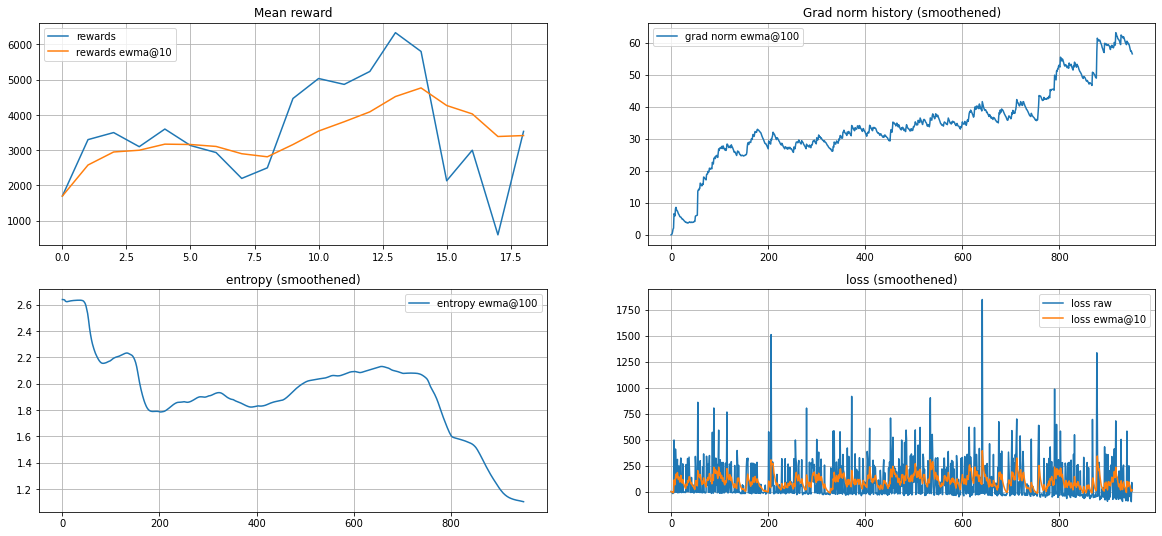

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []
grad_norm_history = []
entropy_history = []
loss_history = []

best_test = 0

agent.train()
max_iter = 0

for i in range(1000):
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(20, verbose=False)      
    loss, grad_norm, entropy = train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)
    grad_norm_history.append(grad_norm)
    entropy_history.append(entropy)
    loss_history.append(loss)
    # print(i)
    if i%50 == 0 and i>0:
        lr*=0.95
        if lr<1e-5:
            lr= 1e-5
        opt = torch.optim.Adam(agent.parameters(), lr=lr)

        agent.eval()
        
        rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
        clear_output(True)
  
        plt.figure(figsize=[20, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward")
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history), span=10), label='rewards ewma@10')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(moving_average(np.array(grad_norm_history), span=100), label='grad norm ewma@100')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("entropy (smoothened)")
        plt.plot(moving_average(np.array(entropy_history), span=100), label='entropy ewma@100')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("loss (smoothened)")
        plt.plot(np.array(loss_history), label='loss raw')
        plt.plot(moving_average(np.array(loss_history), span=10), label='loss ewma@10')
        plt.legend()
        plt.grid()

        plt.show()
        agent.train()

        if rewards_history[-1] >= 15000:
            agent.eval()
            print("Your agent has just passed the minimum homework threshold")
            break
        if rewards_history[-1]>best_test:
            best_test = rewards_history[-1]
            max_iter = 0
            torch.save(agent.state_dict(), '/content/best_model.pth')
        else:
            max_iter+=1
        if max_iter>5:
            agent.load_state_dict(torch.load('/content/best_model.pth'))
            agent.train()
            max_iter = 0

In [ ]:
!rm -r /content/videos
agent.load_state_dict(torch.load('/content/best_model.pth'))
agent.eval()

SimpleRecurrentAgent(
  (ConvLayer): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 32, kernel_size=(3, 5), stride=(2, 4))
    (2): ELU(alpha=1.0)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): ELU(alpha=1.0)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ELU(alpha=1.0)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (hid): Sequential(
    (0): Linear(in_features=1568, out_features=256, bias=True)
    (1): ReLU()
  )
  (rnn): LSTMCell(256, 256)
  (logits): Linear(in_features=256, out_features=14, bias=True)
  (state_value): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:

with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=1)

print("Final mean reward", final_rewards)

# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

Final mean reward [5700.0]


In [ ]:
final_rewards = evaluate(agent, env_monitor, n_games=100)

  0%|          | 0/100 [00:00<?, ?it/s]

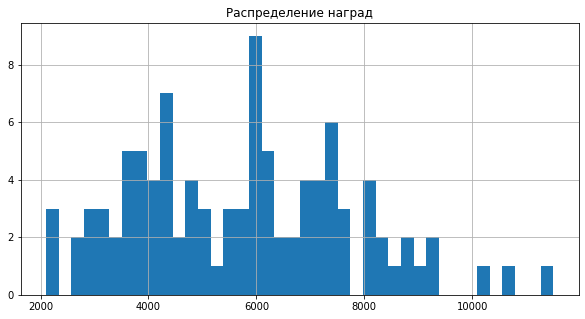

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(final_rewards, bins=40)
plt.grid()
plt.title('Распределение наград')
plt.show()

In [ ]:

with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=1)

print("Final mean reward", final_rewards)

# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

Final mean reward [12600.0]


In [ ]:
best_test

8173.400000000016

<All keys matched successfully>

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

In [ ]:
!rm -r /content/videos
with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=1)

print("Final mean reward", final_rewards)

# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

Final mean reward [8274.799999999808]


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [ ]:

torch.tensor([1,2,3]).numpy()

array([1, 2, 3])

In [ ]:
import torch
import cv2
from PIL import Image
import pandas
detector = torch.hub.load('/content/yolov5', 'custom', path='/content/best_w.pt', source='local', force_reload=True)

YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
new_train_yaml summary: 232 layers, 7251912 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, detector, reuse=False, device=device):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()

        self.detector = detector

        self.ConvLayer = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=(3, 5), stride=(2, 4)),
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ELU(),
            nn.Flatten(1)
        )

        self.emb_npc = nn.Embedding(3, 16)
        self.lin_npc = nn.Linear(1,16)


        self.emb_bul_v = nn.Embedding(2, 16)
        self.lin_bul_v = nn.Linear(1, 16)

        self.emb_bul_h = nn.Embedding(2, 16)
        self.lin_bul_h = nn.Linear(1, 16)


        self.lin_hero_h = nn.Linear(1,16)
        self.lin_hero_v = nn.Linear(1,16)


        self.hid_2 = nn.Sequential(
            nn.Linear(1568, 128),
            nn.LeakyReLU() )

        self.hid_1 = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU() )
        self.rnn = nn.LSTMCell(256, 256)

        self.logits = nn.Linear(256, n_actions)
        self.state_value = nn.Linear(256, 1)
        self.device = device

    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation, 
        returns next state and whatever it needs to learn (tf tensors)
        """
        import collections

        emb_npc, emb_bul_v, emb_bul_h = [], [], []
        lin_npc, lin_bul_h, lin_bul_v, lin_hero_h, lin_hero_v = [], [], [], [], []

        if isinstance(obs_t, torch.Tensor):
             obs_t = obs_t.cpu().numpy()



        for s in obs_t:
            render = s.transpose([1, 2, 0])
            coord = self.get_label_and_coord(render)
            d = collections.defaultdict(list)
            for i in coord:
                d[i[0]].append(i[1:])
            mins = 0
            znak = 2 # 0 слева, 1 справа, 2 нет
            
            if 1 in d:
                for l in d[0]:
                    
                    cur = l[0]  - d[1][0][0]
                    
                    if abs(cur)<mins or not mins:
                        mins = abs(cur)
                        znak = 0 if cur < 0 else 1
            emb_npc.append(znak)
            lin_npc.append(mins)

            cur_h = 0
            cur_v = 0
            znak_h = 0 # 0 нет снизу, 1 есть снизу
            znak_v = 0 # 0 нет сверху, 1 есть сверху 
            
            if 2 in d:
                cur_h = d[2][0][0]  - d[1][0][0]
                cur_v = d[2][0][0]  - d[1][0][1]

                znak_h = 0 if cur_h < 0 else 1
                znak_v = 0 if cur_v < 0 else 1
            
            lin_bul_h.append(abs(cur_h))
            lin_bul_v.append(abs(cur_v))

            emb_bul_h.append(znak_h)
            emb_bul_v.append(znak_v)

            cur_hero_h = 1
            cur_hero_v = 0.48828125

            if 1 in d:
                cur_hero_h = d[1][0][0]
                cur_hero_v = d[1][0][1]

            lin_hero_h.append(cur_hero_h)
            lin_hero_v.append(cur_hero_v)

        x_emb_npc = torch.tensor(emb_npc, dtype=torch.long).to(self.device)
        x_emb_bul_v = torch.tensor(emb_bul_v, dtype=torch.long).to(self.device)
        x_emb_bul_h = torch.tensor(emb_bul_v, dtype=torch.long).to(self.device)

        x_lin_npc  = torch.tensor(lin_npc, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_lin_bul_h = torch.tensor(lin_bul_h, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_lin_bul_v = torch.tensor(lin_bul_v, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_lin_hero_h = torch.tensor(lin_hero_h, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_lin_hero_v = torch.tensor(lin_hero_v, dtype=torch.float32).unsqueeze(1).to(self.device)

        x_emb_npc = self.emb_npc(x_emb_npc)
        x_emb_bul_v = self.emb_bul_v(x_emb_bul_v)
        x_emb_bul_h = self.emb_bul_h(x_emb_bul_h)
        x_lin_npc = self.lin_npc(x_lin_npc)
        x_lin_bul_h = self.lin_bul_h(x_lin_bul_h)
        x_lin_bul_v = self.lin_bul_v(x_lin_bul_v)
        x_lin_hero_h = self.lin_hero_h(x_lin_hero_h)
        x_lin_hero_v = self.lin_hero_v(x_lin_hero_v)

        
        x_1 = torch.cat((x_emb_npc, x_emb_bul_v, x_emb_bul_h, x_lin_npc, x_lin_bul_h, x_lin_bul_v, x_lin_hero_h, x_lin_hero_v), dim=1)
        x_1 = self.hid_1(x_1)
        obs_t = torch.tensor(obs_t / 255, dtype=torch.float32).to(self.device) 
        x = self.ConvLayer(obs_t)
        x_2 = self.hid_2(x)
        x = torch.cat((x_1, x_2), dim=1)
        new_state = self.rnn(x, prev_state)
        y = new_state[0]
        logits = self.logits(new_state[0])
        state_value = self.state_value(y)
        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return torch.zeros((batch_size, 256)).to(self.device), torch.zeros((batch_size, 256)).to(self.device)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits, dim=-1).cpu()
        return torch.multinomial(probs, 1)[:, 0].data.numpy()

    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is a numpy array """
        
        with torch.no_grad():
            (h, c), (l, s) = self.forward(prev_state, obs_t)
        return (h.detach(), c.detach()), (l.detach(), s.detach())

    def get_label_and_coord(self, render):
        results = self.detector(render)
        coord = results.pandas().xywh[0][['class', 'xcenter', 'ycenter','width','height' ]].values
        
        return coord
    
 

In [ ]:
results = detector(s.transpose([1,2,0]))
results.pandas().xywh[0]

Empty DataFrame
Columns: [xcenter, ycenter, width, height, confidence, class, name]
Index: []

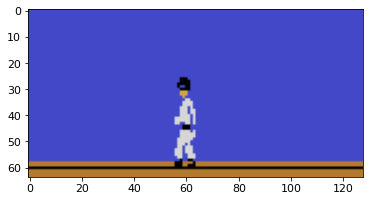

In [ ]:
plt.imshow()

In [ ]:
n_parallel_games = 9
gamma = 0.99

agent = SimpleRecurrentAgent(obs_shape, n_actions, detector, device=device).to(device)

In [ ]:
! rm -r videos
with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    rw = evaluate(agent, env_monitor, n_games=3)
print(rw)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []
grad_norm_history = []
entropy_history = []
loss_history = []

best_test = 0

lr = 1e-3
opt = torch.optim.Adam(agent.parameters(), lr=lr)
n_parallel_games = 3
pool = EnvPool(agent, make_env, n_parallel_games)

agent.train()
max_iter = 0

for i in range(1000):
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(20, verbose=False)      
    loss, grad_norm, entropy = train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)
    grad_norm_history.append(grad_norm)
    entropy_history.append(entropy)
    loss_history.append(loss)
    print(i)
    if i%2 == 0 and i>0:
        lr*=0.95
        if lr<1e-5:
            lr= 1e-5
        opt = torch.optim.Adam(agent.parameters(), lr=lr)

        agent.eval()
        
        rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
        clear_output(True)
  
        plt.figure(figsize=[20, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward")
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history), span=10), label='rewards ewma@10')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(moving_average(np.array(grad_norm_history), span=100), label='grad norm ewma@100')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("entropy (smoothened)")
        plt.plot(moving_average(np.array(entropy_history), span=100), label='entropy ewma@100')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("loss (smoothened)")
        plt.plot(np.array(loss_history), label='loss raw')
        plt.plot(moving_average(np.array(loss_history), span=10), label='loss ewma@10')
        plt.legend()
        plt.grid()

        plt.show()
        agent.train()

        if rewards_history[-1] >= 15000:
            agent.eval()
            print("Your agent has just passed the minimum homework threshold")
            break
        if rewards_history[-1]>best_test:
            best_test = rewards_history[-1]
            max_iter = 0
            torch.save(agent.state_dict(), '/content/best_model.pth')
        else:
            max_iter+=1
        if max_iter>5:
            agent.load_state_dict(torch.load('/content/best_model.pth'))
            agent.train()
            max_iter = 0

In [ ]:
agent.load_state_dict(torch.load('/content/best_model.pth'))
agent.eval()
print(1)

1


In [ ]:
!rm -r /content/videos
with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=1)

print("Final mean reward", final_rewards)

# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

Final mean reward [10000.0]


In [ ]:
final_rewards = evaluate(agent, env_monitor, n_games=100)

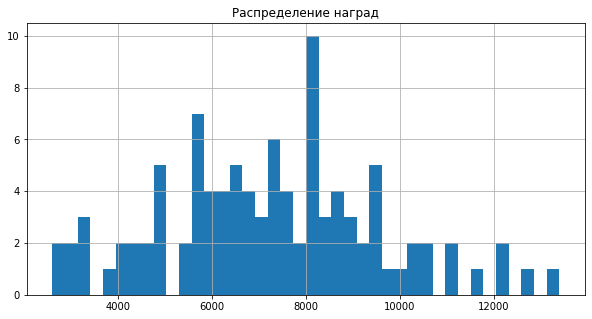

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(final_rewards, bins=40)
plt.grid()
plt.title('Распределение наград')
plt.show()

In [ ]:
!rm -r /content/videos
with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=1)

print("Final mean reward", final_rewards)

# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

Final mean reward [6800.0]
